In [93]:
import pandas as pd

In [94]:

ev_sales = pd.read_csv('./IEA-EV-dataEV salesHistoricalCars.csv')
# https://www.iea.org/data-and-statistics/data-tools/global-ev-data-explorer

ev_sales = ev_sales[(ev_sales['parameter'] == 'EV sales') & (ev_sales['mode'] == 'Cars') & (ev_sales['region'] == 'USA')]

fcev_sales = ev_sales[ev_sales['powertrain'] == 'FCEV']
ev_sales = ev_sales[ev_sales['powertrain'] != 'FCEV']

fcev_sales = fcev_sales.groupby('year')['value'].sum().reset_index().rename(columns={'value': 'sales'})
ev_sales = ev_sales.groupby('year')['value'].sum().reset_index().rename(columns={'value': 'sales'})

fcev_sales = pd.concat([fcev_sales, pd.DataFrame({
    'year': range(2010, 2014),
    'sales': 0
})], ignore_index=True).sort_values('year').reset_index(drop=True)

In [95]:
total_sales = pd.read_csv('./TOTALSA.csv')
# https://fred.stlouisfed.org/series/TOTALSA

total_sales['TOTALSA'] = total_sales['TOTALSA'] * 1_000_000

total_sales['DATE'] = pd.to_datetime(total_sales['DATE'])

total_sales['year'] = total_sales['DATE'].dt.year

total_sales = total_sales.groupby('year')['TOTALSA'].sum().reset_index().rename(columns={'TOTALSA': 'sales'})

total_sales = total_sales[(total_sales['year'] >= 2010) & (total_sales['year'] <= 2023)].reset_index(drop=True)

total_sales['sales'] = total_sales['sales'] - ev_sales['sales'] - fcev_sales['sales']

ev_sales.to_csv('./ev_sales.csv', index=False)
fcev_sales.to_csv('./fcev_sales.csv', index=False)
total_sales.to_csv('./total_sales.csv', index=False)

In [96]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [97]:
def bass_model(t, p, q, m):
    adoption = np.zeros(t.size)
    adoption[0] = (p + q) / (1 + q) * m
    for i in range(1, t.size):
        adoption[i] = ((p + q * (adoption[:i].sum() / m)) /
                       (1 + q * (adoption[:i].sum() / m))) * (m - adoption[:i].sum())
    return adoption.cumsum()


In [98]:
years = np.arange(ev_sales['year'].min(), ev_sales['year'].max() + 1)

years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023], dtype=int64)

In [99]:
popt, pcov = curve_fit(bass_model, years, total_sales['sales'], p0=[0.001, 10, max(total_sales['sales']) * 1.5])


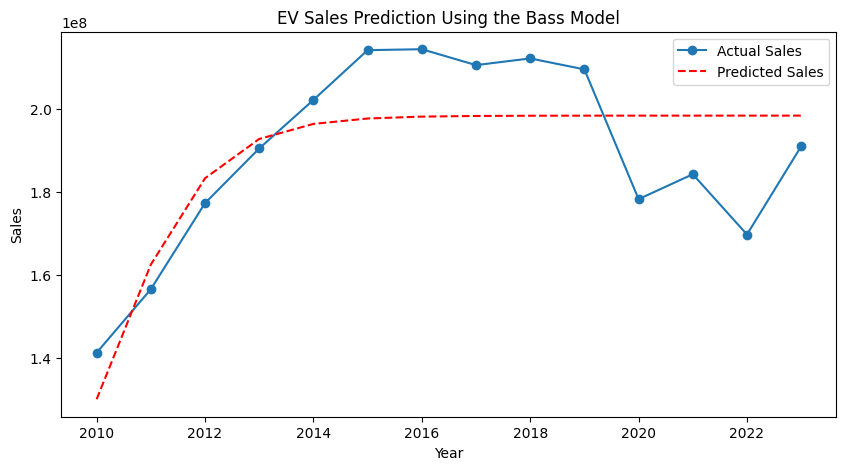

In [100]:
predicted_sales = bass_model(years, *popt)

plt.figure(figsize=(10, 5))
plt.plot(years, total_sales['sales'], 'o-', label='Actual Sales')
plt.plot(years, predicted_sales, 'r--', label='Predicted Sales')
plt.title('EV Sales Prediction Using the Bass Model')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.show()
